<a href="https://colab.research.google.com/github/ipavlopoulos/compauth/blob/main/analysing_iliad_and_odyssey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Modelling for Computational Authorship Analysis
* Application on the Iliad and the Odyssey.

# Homeric Book Processing

In [2]:
# install the required packages
%%capture
! pip install tei_reader
! pip install transformers
! git clone https://github.com/ipavlopoulos/lm.git

In [3]:
import re
from tei_reader import TeiReader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
sns.set_theme(style="whitegrid"); 
import numpy as np; np.random.seed=42
from lm.markov.models import LM as SLM
from sklearn.metrics import *
from tqdm.notebook import tqdm

In [4]:
punct = [u"'", "'", u",", ",",u".",".",u"``","``",u"''","''",u'"','"',u"[","[",u"]","]",u">",">",u"<","<",u"⸖","⸖",u"※","※",u"—","—",u"•","•",u"Ͻ","Ͻ",u"ͽ",u"ͻ",u"ͼ",u"Ͼ","Ͼ",u"Ͽ","Ͽ",u"ras","ras",u"corr","corr",u";",";",u"·",'·',u"‘","‘",u"’","’",u"†","†","–",u"–","⏑",u"⏑"]
punct_regex = re.compile("(%s)" % "|".join(map(re.escape, punct)))

In [40]:
WINDOW_SIZE = 600
N = 4
POOL_SIZE = 100

In [6]:
def traintest_sample(text, w=POOL_SIZE, window=WINDOW_SIZE):
  assert w>1 
  # Define a large window
  large_window = w * window
  # Find a random spot
  text_start = np.random.randint(0, len(text)-large_window)
  # Define the test pool
  test = text[text_start:text_start+large_window]
  # The rest is train
  train = text[:text_start] + " " + text[text_start+large_window:]
  # Define a test set from the pool
  text_start = np.random.randint(0, len(test)-window)
  test = test[text_start:text_start+window]
  return train, test

def sample(text, window=WINDOW_SIZE):
  text_start = np.random.randint(0, len(text)-window)
  return text[text_start:text_start+window]

def traintest_fixed(text, 
                    outer_window_factor=POOL_SIZE,  # creating a larger window, to create the train corpus 
                    window=WINDOW_SIZE, # the size of the fragment 
                    text_start=None # leave this to None, to sample the fragment
                    ):
  assert outer_window_factor > 1 
  # Define an outer window on the left and on the right
  outer_window = outer_window_factor * window
  # Find a random spot
  if text_start is None:
    text_start = np.random.randint(0, len(text)-outer_window)
  left_window = max(0, text_start - outer_window)
  right_window = text_start + outer_window
  # Define the test pool
  test = text[text_start:text_start+window]
  # The rest is train
  train = text[:left_window] + " " + text[right_window:]
  return train, test

In [7]:
def create_cis(unseen_text, raw, 
               grams_num=N, 
               repetitions=100, 
               gold_pool_x=POOL_SIZE,
               window=WINDOW_SIZE,
               score=None):
  """
  Build a character language model using the raw corpus and compute the BPC of a
  window-sized fragment, sampled from a gold_pool*window-sized text of the same 
  corpus (control). Compute the BPC of a window-sized sample of an unseen_text
  and compare the two BPC scores. If the unseen is lower than the control, 
  increase a counter and the repeat. The counter to the repetitions is 
  the P-value that the unseen text is linguistically indistinguishable from the
  raw corpus, given the chosen model. 

  @unseen_text: the text that is assumed to be part of the corpus
  @raw: the corpus
  @grams_num: the number of grams (characters/words) of the s. language model
  @repetitions: the more the better for st. significance
  @window: the size of the unseen and seen samples
  @gold_pool_x: the factor multiplied with the window, to sample the seen text
  @return: a dataframe incl. the paired sample and control BPCs
  """
  samples, controls = [], []
  for i in tqdm(range(repetitions)):
    # create a train/test split from the seen corpus
    trainset, control_test = traintest_fixed(raw, outer_window_factor=gold_pool_x, window=window)
    # sample a fragment from the unseen text 
    unseen_test = sample(unseen_text, window=window)
    # build the LM using the seen trainset 
    lm = SLM(gram="CHAR", n=grams_num).train(trainset)
    # compare the seen-test with the unseen sample
    unseen_score = score(lm, unseen_test) if score is not None else lm.cross_entropy(unseen_test)
    cntrl_score = score(lm, control_test) if score is not None else lm.cross_entropy(control_test) 
    samples.append(unseen_score)
    controls.append(cntrl_score)
  # register how many times was the unseen closer than the seen    
  repetitions = pd.DataFrame({"Sample":samples, "Control":controls})
  return repetitions

In [9]:
# The Homeric Corpus
reader = TeiReader()
iliad = reader.read_file('iliad.xml').text
odyssey = reader.read_file('odyssey.xml').text
# The Books
iliad_rhapsodies = [re.sub(punct_regex, "", r[3:].lower().strip()) for r in iliad.split("ΙΛΙΑΔΟΣ")[1:]]
odyss_rhapsodies = [re.sub(punct_regex, "", r[3:].lower().strip()) for r in odyssey.split("ΟΔΥΣΣΕΙΑΣ")[1:]]
pd.Series(iliad_rhapsodies).to_csv("iliad.csv", index=False)
pd.Series(odyss_rhapsodies).to_csv("odyss.csv", index=False)

In [22]:
iliad_books = pd.read_csv("iliad.csv").iloc[:, 0].tolist()
odyss_books = pd.read_csv("odyss.csv").iloc[:, 0].tolist()

In [23]:
# Text hide & seek as an objective
raw_iliad, raw_odyss = "", ""
for book in iliad_rhapsodies: raw_iliad += " " + book
for book in odyss_rhapsodies: raw_odyss += " " + book

###### From BPC to PPL.
* BPC is the average negative log probability per character of a text, based on a character-level language model.
* PPL, which is the standard for word-level language models, can be seen as the exponential of BPC, weighted by the average token level.
* Based on the work of [Graves (2013)](https://arxiv.org/pdf/1308.0850.pdf).

In [30]:
print(f"Average word length: {np.mean([len(t) for t in set(raw_iliad.split())]):.1f} for Iliad and {np.mean([len(t) for t in set(raw_odyss.split())]):.1f} for Odyssey.")
print(f"Average token length: {np.mean([len(t) for t in raw_iliad.split()]):.1f} for Iliad and {np.mean([len(t) for t in raw_odyss.split()]):.1f} for Odyssey.")
ppl_adj = lambda lm, text, f=4.9: np.power(2, f*lm.cross_entropy(text))

Average word length: 7.2 for Iliad and 7.1 for Odyssey.
Average token length: 4.9 for Iliad and 4.9 for Odyssey.


# Sanity check
* Testing Iliad fragments using an Iliad LM.
* Using a big outer window ensures that the control fragment will not be close to the training corpus (hence yielding consistently low BPC).
* Non-parametric tests some times fail to lead to the result that Iliad fragments are not from the Iliad LM (build on text preceding the test text). The hypothesis then would be that if the same tests for other texts give a low P-value (5% or lower), then this would indicate a liguistic distance for the tested text. 
* However, other times the tests do not fail and provide st. sigificance that the Iliad text is not from Iliad. This method is not valid as it is. 

In [41]:
cut = int(len(raw_iliad)/2)
df = create_cis(raw_iliad[cut:], raw=raw_iliad[:cut], score=ppl_adj)
print("Wilcoxon P-value:", wilcoxon(df.Sample, df.Control)[1])
print("Mann-Whitney P-value:", mannwhitneyu(df.Sample, df.Control)[1])

  0%|          | 0/100 [00:00<?, ?it/s]

Wilcoxon P-value: 0.17882391733984515
Mann-Whitney P-value: 0.11021989457535203


In [42]:
cut = int(len(raw_odyss)/2)
df = create_cis(raw_odyss[cut:], raw=raw_odyss[:cut], score=ppl_adj)
print("Wilcoxon P-value:", wilcoxon(df.Sample, df.Control)[1])
print("Mann-Whitney P-value:", mannwhitneyu(df.Sample, df.Control)[1])

  0%|          | 0/100 [00:00<?, ?it/s]

Wilcoxon P-value: 0.24100890272556064
Mann-Whitney P-value: 0.09209204980030528


# The Hesiod-Not-Homer (HnH) sanity check
* Compute the BPC of a language model trained on all but one excerpt, when applied on fragments of the missing excerpt.
* Compare the above control BPC with that computed on an unseen text of the same length.
* Repeat the experiment above and report the fraction of times that the control BPC was higher than the one of the unseen text (P-value). 
* Investigate sources that yield a P-value lower than 5%. 

In [44]:
hesiod = pd.read_csv("Hesiod_works_and_days.txt", sep="\n", header=None, names=["text"])
print(f"{hesiod.shape[0]} verses parsed")
hesiod.sample()

831 verses parsed


,text
591,"εἴη πετραίη τε σκιὴ καὶ βίβλινος οἶνος,"


In [45]:
hesiod_txt = " ".join(hesiod.text.str.strip().to_list())
hesiod_txt = re.sub(punct_regex, "", hesiod_txt.lower().strip())
print(len(hesiod_txt))
hesiod_txt[:100]

36203


'μοῦσαι πιερίηθεν ἀοιδῇσιν κλείουσαι δεῦτε δί᾽ ἐννέπετε σφέτερον πατέρ᾽ ὑμνείουσαι: ὅντε διὰ βροτοὶ ἄ'

In [47]:
# gold_pool_x=100 gives the same result
df = create_cis(hesiod_txt, raw=raw_iliad, score=ppl_adj, gold_pool_x=10)
print(f"95% CIs for Hesiod: {df.Sample.quantile(.025):.2f} to {df.Sample.quantile(.975):.2f}")
print("Wilcoxon P-value:", wilcoxon(df.Sample, df.Control)[1])
print("Mann-Whitney P-value:", mannwhitneyu(df.Sample, df.Control)[1])

  0%|          | 0/100 [00:00<?, ?it/s]

95% CIs for Hesiod: 8241.40 to 360750.51
Wilcoxon P-value: 4.0161556854627e-18
Mann-Whitney P-value: 2.7100664154098146e-34


In [48]:
# gold_pool_x=100 gives the same result
df = create_cis(hesiod_txt, raw=raw_odyss, score=ppl_adj, gold_pool_x=10)
print(f"95% CIs for Hesiod: {df.Sample.quantile(.025):.2f} to {df.Sample.quantile(.975):.2f}")
print("Wilcoxon P-value:", wilcoxon(df.Sample, df.Control)[1])
print("Mann-Whitney P-value:", mannwhitneyu(df.Sample, df.Control)[1])

  0%|          | 0/100 [00:00<?, ?it/s]

95% CIs for Hesiod: 11169.81 to 582694.65
Wilcoxon P-value: 3.896559845095909e-18
Mann-Whitney P-value: 2.3656639767043247e-33


* Same for Theogony

In [49]:
import json
from bs4 import BeautifulSoup as Soup

hesiod_json = json.loads(open("Hesiod-Theogony.json").read())
hesiod_xml = hesiod_json["booksRaw"][0]["bookText"]
theogony_soup = Soup(hesiod_xml)
theogony_text = theogony_soup.text
theogony_verses = [v for v in theogony_text.split("\n") if len(set(v))>1]
print(len(theogony_verses))
print(len(" ".join(theogony_verses)))

1042
45813


In [50]:
# gold_pool_x=100 gives the same result
df = create_cis(" ".join(theogony_verses), raw=raw_iliad, score=ppl_adj, gold_pool_x=10)
print(f"95% CIs for Hesiod-Theogony: {df.Sample.quantile(.025):.2f} to {df.Sample.quantile(.975):.2f}")
print("Wilcoxon P-value:", wilcoxon(df.Sample, df.Control)[1])
print("Mann-Whitney P-value:", mannwhitneyu(df.Sample, df.Control)[1])

  0%|          | 0/100 [00:00<?, ?it/s]

95% CIs for Hesiod-Theogony: 48311.04 to 1647746.17
Wilcoxon P-value: 3.896559845095909e-18
Mann-Whitney P-value: 1.2810718345817004e-34


In [51]:
# gold_pool_x=100 gives the same result
df = create_cis(" ".join(theogony_verses), raw=raw_odyss, score=ppl_adj, gold_pool_x=10)
print(f"95% CIs for Hesiod-Theogony: {df.Sample.quantile(.025):.2f} to {df.Sample.quantile(.975):.2f}")
print("Wilcoxon P-value:", wilcoxon(df.Sample, df.Control)[1])
print("Mann-Whitney P-value:", mannwhitneyu(df.Sample, df.Control)[1])

  0%|          | 0/100 [00:00<?, ?it/s]

95% CIs for Hesiod-Theogony: 47015.02 to 3218909.07
Wilcoxon P-value: 3.896559845095909e-18
Mann-Whitney P-value: 1.2810718345817004e-34


* Plotting the PPL of Theogony based on the Oddyssey Model, for better understanding.

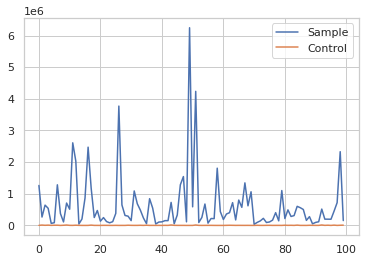

In [52]:
df.plot();

# Genesis Modeling

In [53]:
a = pd.read_csv("genesis_A.txt", sep="\t", names=["text"])
b = pd.read_csv("genesis_B.txt", sep="\t", names=["text"])

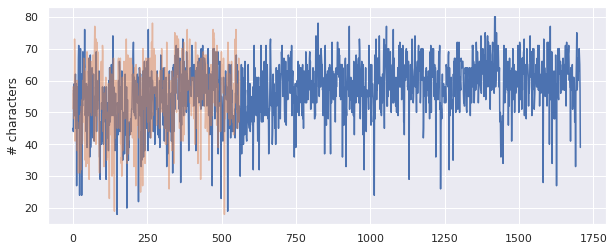

In [54]:
sns.set(rc={'figure.figsize':(10,4)})
a.text.apply(len).plot(); b.text.apply(len).plot(alpha=.5); plt.ylabel("# characters");

In [55]:
pd.DataFrame({"A":[len(a.text.sum())], "B":[len(b.text.sum())]})

,A,B
0,97628,30406


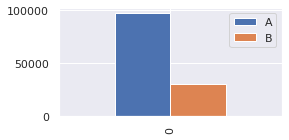

In [56]:
sns.set(rc={'figure.figsize':(4,2)})
pd.DataFrame({"A":[len(a.text.sum())], "B":[len(b.text.sum())]}).plot.bar();

In [57]:
# gold_pool_x=100 gives the same result
df = create_cis(" ".join(b.text).lower(), raw=" ".join(a.text).lower(), score=ppl_adj, gold_pool_x=10)
print(f"95% CIs for Hesiod: {df.Sample.quantile(.025):.2f} to {df.Sample.quantile(.975):.2f}")
print("Wilcoxon P-value:", wilcoxon(df.Sample, df.Control)[1])
print("Mann-Whitney P-value:", mannwhitneyu(df.Sample, df.Control)[1])

  0%|          | 0/100 [00:00<?, ?it/s]

95% CIs for Hesiod: 616.22 to 4952.25
Wilcoxon P-value: 2.766870616083989e-09
Mann-Whitney P-value: 1.9884099641752354e-12


# Analysing the Homeric poems
* Fragment level analysis.
* Assessing the linguistic proximity with the remaining corpus by using bits/character (BPC).
* Computing 95% confidence intervals of the BPC of random fragments of the corpus, then using them to detect the deviating fragments. 

### Iliad

In [ ]:
# Sample text, train on the rest, report the PPL of the LM on the sample
iliad_samples = []
print("Training all but an excerpt, testing on the excerpt.")
for i in tqdm(range(1000)):
  iliad_trainset, iliad_testset = traintest_fixed(raw_iliad)
  ilm = SLM(gram="CHAR").train(iliad_trainset)
  iliad_samples.append(ppl_adj(ilm, iliad_testset))
print(f"95% CIs: {pd.Series(iliad_samples).quantile(.025):.2f} to {pd.Series(iliad_samples).quantile(.975):.2f}")

Training all but an excerpt, testing on the excerpt.


  0%|          | 0/1000 [00:00<?, ?it/s]

95% CIs: 550.53% to 17300.38%


### Odyssey

In [ ]:
print("Odyssey")
samples = []
for i in tqdm(range(1000)):
  trainset, testset = traintest_fixed(raw_odyss)
  lm = SLM(gram="CHAR").train(trainset)
  samples.append(ppl_adj(lm, testset))

out = pd.Series(samples)
print(f"The 95% CIs for Odyssey are: {out.quantile(.025):.2f} to {out.quantile(.975):.2f}")

Odyssey


  0%|          | 0/1000 [00:00<?, ?it/s]

The 95% CIs for Odyssey are: 452.51 to 25838.27


In [ ]:
# The 95% upper CI threshold of the two poems
THRESHOLD_I = 17300
THRESHOLD_O = 25838

# Intra-poem analysis of Homeric text.
* Search for fragments that score high.

In [ ]:
def create_ts(poem, threshold, window=WINDOW_SIZE):
  x, y, texts = range(1, len(poem)-window, window), [], []
  for cut in tqdm(x):
    trainset, testset = traintest_fixed(poem, text_start=cut)
    lm = SLM(gram="CHAR").train(trainset)
    score = ppl_adj(lm, testset)
    y.append(score)
    texts.append(testset)
    if score>threshold:
      print(f"Score: {score:.4f} for the following excerpt ({cut} verse in raw)\n{testset}\n.")
  return pd.DataFrame({"Index":x, "Text": texts, "PPL":y})

* Iliad:

In [ ]:
ili_ts = create_ts(raw_iliad, threshold=THRESHOLD_I)

  0%|          | 0/1110 [00:00<?, ?it/s]

Score: 18374.2284 for the following excerpt (38401 verse in raw)
ε γυναῖκες ἀλλήλοισιν ὀδύρονται οἶκον δὲ νέεσθαι  ἦ μὴν καὶ πόνος ἐστὶν ἀνιηθέντα νέεσθαι καὶ γάρ τίς θ ἕνα μῆνα μένων ἀπὸ ἧς ἀλόχοιο ἀσχαλάᾳ σὺν νηῒ πολυζύγῳ ὅν περ ἄελλαι χειμέριαι εἰλέωσιν ὀρινομένη τε θάλασσα ἡμῖν δ εἴνατός ἐστι περιτροπέων ἐνιαυτὸς ἐνθάδε μιμνόντεσσι τὼ οὐ νεμεσίζομ ἀχαιοὺς  ἀσχαλάαν παρὰ νηυσὶ κορωνίσιν ἀλλὰ καὶ ἔμπης αἰσχρόν τοι δηρόν τε μένειν κενεόν τε νέεσθαι  τλῆτε φίλοι καὶ μείνατ ἐπὶ χρόνον ὄφρα δαῶμεν  ἢ ἐτεὸν κάλχας μαντεύεται ἦε καὶ οὐκί εὖ γὰρ δὴ τόδε ἴδμεν ἐνὶ φρεσίν ἐστὲ δὲ πάντες  μάρτυροι οὓς μὴ κῆρες ἔβαν θανάτοιο φέρουσαι χθιζά τε καὶ πρωΐζ ὅτ ἐς αὐλίδα 
.
Score: 29321.0872 for the following excerpt (39001 verse in raw)
νῆες ἀχαιῶν ἠγερέθοντο κακὰ πριάμῳ καὶ τρωσὶ φέρουσαι ἡμεῖς δ ἀμφὶ περὶ κρήνην ἱεροὺς κατὰ βωμοὺς ἕρδομεν ἀθανάτοισι τεληέσσας ἑκατόμβας καλῇ ὑπὸ πλατανίστῳ ὅθεν ῥέεν ἀγλαὸν ὕδωρ ἔνθ ἐφάνη μέγα σῆμα δράκων ἐπὶ νῶτα δαφοινὸς σμερδαλέος τόν ῥ αὐτὸς ὀλύμπιος ἧκε φόως δέ

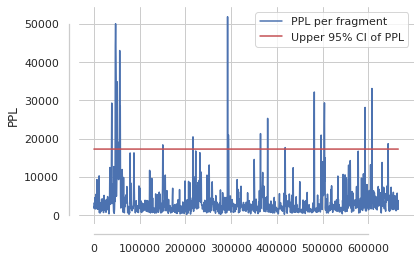

In [ ]:
ax = sns.lineplot(data=ili_ts,y="PPL", x="Index", label="PPL per fragment");
plt.plot(ili_ts.Index, [THRESHOLD_I]*ili_ts.shape[0], label="Upper 95% CI of PPL", color="r")
sns.set_style("whitegrid");sns.despine(offset=10, trim=True); ax.set(xlabel=None);
plt.legend(loc="upper right");

* Odyssey

In [ ]:
ody_ts = create_ts(raw_odyss, THRESHOLD_O)

  0%|          | 0/857 [00:00<?, ?it/s]

Score: 26311.2423 for the following excerpt (55801 verse in raw)
οἷσίν τε χρυσὸν ἐργάζετο ἦλθε δ ἀθήνη ἱρῶν ἀντιόωσα γέρων δ ἱππηλάτα νέστωρ χρυσὸν ἔδωχ ὁ δ ἔπειτα βοὸς κέρασιν περίχευεν ἀσκήσας ἵν ἄγαλμα θεὰ κεχάροιτο ἰδοῦσα βοῦν δ ἀγέτην κεράων στρατίος καὶ δῖος ἐχέφρων χέρνιβα δέ σφ ἄρητος ἐν ἀνθεμόεντι λέβητι ἤλυθεν ἐκ θαλάμοιο φέρων ἑτέρῃ δ ἔχεν οὐλὰς ἐν κανέῳ πέλεκυν δὲ μενεπτόλεμος θρασυμήδης ὀξὺν ἔχων ἐν χειρὶ παρίστατο βοῦν ἐπικόψων περσεὺς δ ἀμνίον εἶχε γέρων δ ἱππηλάτα νέστωρ χέρνιβά τ οὐλοχύτας τε κατήρχετο πολλὰ δ ἀθήνῃ εὔχετ ἀπαρχόμενος κεφαλῆς τρίχας ἐν πυρὶ βάλλων αὐτὰρ ἐπεί ῥ εὔξαντο καὶ οὐλοχύτας προβάλοντο αὐτίκα νέστορος υἱός ὑπέρθυμος θ
.
Score: 27343.4180 for the following excerpt (96601 verse in raw)
ϊφόντης πιερίην δ ἐπιβὰς ἐξ αἰθέρος ἔμπεσε πόντῳ σεύατ ἔπειτ ἐπὶ κῦμα λάρῳ ὄρνιθι ἐοικώς ὅς τε κατὰ δεινοὺς κόλπους ἁλὸς ἀτρυγέτοιο ἰχθῦς ἀγρώσσων πυκινὰ πτερὰ δεύεται ἅλμῃ τῷ ἴκελος πολέεσσιν ὀχήσατο κύμασιν ἑρμῆς ἀλλ ὅτε δὴ τὴν νῆσον ἀφίκετο τηλόθ ἐοῦσαν ἔνθ ἐκ πόν

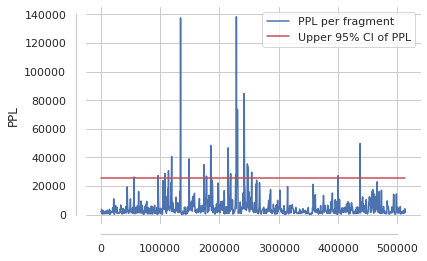

In [ ]:
ax = sns.lineplot(data=ody_ts, y="PPL", x="Index", label="PPL per fragment");
plt.plot(ody_ts.Index, [THRESHOLD_O]*ody_ts.shape[0], label="Upper 95% CI of PPL", color="r")
sns.set_style("whitegrid");sns.despine(offset=10, trim=True); ax.set(xlabel=None);
plt.legend(loc="upper right");

In [ ]:
ili_ts.to_excel("ts_iliad.xlsx")
ody_ts.to_excel("ts_odyss.xlsx")

In [ ]:
ili_ts[ili_ts.PPL>THRESHOLD_I].to_excel("iliad_ts_filtered.xlsx")
ody_ts[ody_ts.PPL>THRESHOLD_O].to_excel("odyss_ts_filtered.xlsx")

#### Fine-grained intra-poem analysis

In [ ]:
def create_fine_ts(poem, threshold, window=600, target=1, fine_window=10, rolling=-1):
  # compute the fragment's BPC from an out-of-fragment-trained LM
  testset  = poem[target:target+window] 
  trainset = poem[:target] + " " + poem[target+window:]
  lm = SLM(gram="CHAR").train(trainset)
  score = ppl_adj(lm, testset)
  if score>threshold:
    print(f"Score: {score} for the following excerpt\n{testset}\n({target} verse in raw).")
  cuts, bpcs, fragments = [], [], []
  for cut in range(1, len(testset)-fine_window, fine_window if rolling<0 else rolling):
    cuts.append(target+cut)
    ftestset = testset[cut:cut+fine_window]
    bpcs.append(ppl_adj(lm, ftestset))
    fragments.append(ftestset)
  return pd.DataFrame({"Verse":cuts, "PPL":bpcs, "Text":fragments})

In [ ]:
def create_word_ts(poem, threshold, window=600, target=1):
  # compute the fragment's word BPC from an out-of-fragment-trained-LM
  testset  = poem[target:target+window] 
  trainset = poem[:target] + " " + poem[target+window:]
  lm = SLM(gram="CHAR").train(trainset)
  score = ppl_adj(lm, testset)
  if score>threshold:
    print(f"Score: {score} for the following excerpt\n{testset}\n({target} verse in raw).")
  words = testset.split()
  bpcs, fragments = [], []
  for word in words:
    bpcs.append(ppl_adj(lm, " "+word))
  return pd.DataFrame({"Verse":range(len(words)), "PPL":bpcs, "Text":words})

In [ ]:
ts = create_fine_ts(raw_odyss, THRESHOLD_O, target=400201, fine_window=40, rolling=5)
#ts = create_word_ts(raw_odyss, o_thresh, target=44401)

Score: 28570.006737734082 for the following excerpt
εσσί γε δώσεις πλείοσιν ἢ ἔχομαι ἡ γὰρ δίκη ὁππότε πάτρης ἧς ἀπέῃσιν ἀνὴρ τόσσον χρόνον ὅσσον ἐγὼ νῦν πολλὰ βροτῶν ἐπὶ ἄστε ἀλώμενος ἄλγεα πάσχων ἀλλὰ καὶ ὧς ἐρέω ὅ μ ἀνείρεαι ἠδὲ μεταλλᾷς κρήτη τις γαῖ ἔστι μέσῳ ἐνὶ οἴνοπι πόντῳ καλὴ καὶ πίειρα περίρρυτος ἐν δ ἄνθρωποι πολλοὶ ἀπειρέσιοι καὶ ἐννήκοντα πόληες  ἄλλη δ ἄλλων γλῶσσα μεμιγμένη ἐν μὲν ἀχαιοί ἐν δ ἐτεόκρητες μεγαλήτορες ἐν δὲ κύδωνες δωριέες τε τριχάϊκες δῖοί τε πελασγοί  τῇσι δ ἐνὶ κνωσός μεγάλη πόλις ἔνθα τε μίνως ἐννέωρος βασίλευε διὸς μεγάλου ὀαριστής πατρὸς ἐμοῖο πατήρ μεγαθύμου δευκαλίωνος δευκαλίων δ ἐμὲ τίκτε καὶ ἰδομενῆα ἄνα
(400201 verse in raw).


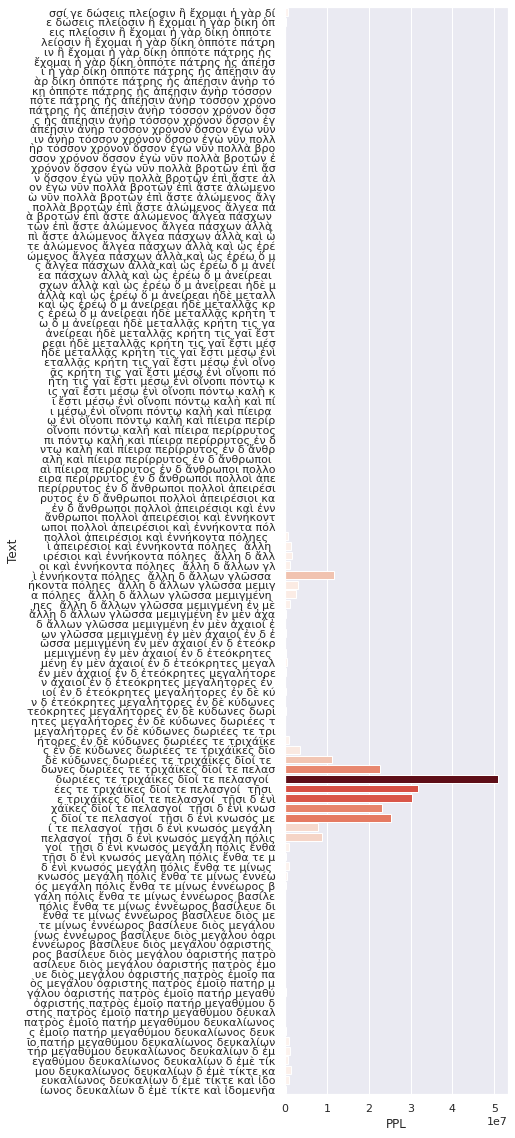

In [ ]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

sns.set(rc={'figure.figsize':(4,20)})
sns.barplot(data=ts, x="PPL", y="Text", palette=colors_from_values(ts.PPL, "Reds"));

# Bookwise Language Modeling
* Train a model on all but two books.
* Use the model to compute BPCs on fragments from these books. 

In [ ]:
iliad_training = " ".join([b for j,b in enumerate(iliad_rhapsodies) if j !=1]) 
odyss_training = " ".join([b for j,b in enumerate(odyss_rhapsodies) if j !=10]) 

In [ ]:
def create_book_ts(lm, book, window=WINDOW_SIZE):
  x, y, texts = range(1, len(book)-window, window), [], []
  for cut in tqdm(x):
    fragment = book[cut:cut+window]
    #score = lm.cross_entropy(fragment)
    score = ppl_adj(lm, fragment)
    y.append(score)
    texts.append(fragment)
  return pd.DataFrame({"Index":x, "Text": texts, "PPL":y})

In [ ]:
samples = []
for i in tqdm(range(100)):
  trainset, testset = traintest_fixed(iliad_training)
  lm = SLM(gram="CHAR").train(trainset)
  samples.append(ppl_adj(lm, testset))
out = pd.Series(samples)
print(f"The 95% CIs for Iliad are: {out.quantile(.025):.2f} to {out.quantile(.975):.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

The 95% CIs for Iliad are: 763.97 to 9499.61


In [ ]:
samples = []
for i in tqdm(range(100)):
  trainset, testset = traintest_fixed(odyss_training)
  lm = SLM(gram="CHAR").train(trainset)
  samples.append(ppl_adj(lm, testset))
out = pd.Series(samples)
print(f"The 95% CIs for Odyssey are: {out.quantile(.025):.2f}% to {out.quantile(.975):.2f}%")

  0%|          | 0/100 [00:00<?, ?it/s]

The 95% CIs for Odyssey are: 411.40% to 22881.52%


* Iliad LM, trained on all but B2, and scored on B2.
* Odyssey LM, same for B11.

In [ ]:
i_trainset, i_testset = traintest_fixed(iliad_training)
o_trainset, o_testset = traintest_fixed(odyss_training)
ilm = SLM(gram="CHAR").train(i_trainset)
olm = SLM(gram="CHAR").train(o_trainset)
ib2 = create_book_ts(ilm, iliad_rhapsodies[1])
ob11 = create_book_ts(ilm, odyss_rhapsodies[10])
ib2.to_excel("I2.xlsx", index=False)
ob11.to_excel("O11.xlsx", index=False)
#ib2[ib2.PPL>19540].to_csv("ib2.out-of-95cis.csv", index=False)
#ob11[ob11.PPL>18710].to_csv("ob10.out-of-95cis.csv", index=False)

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

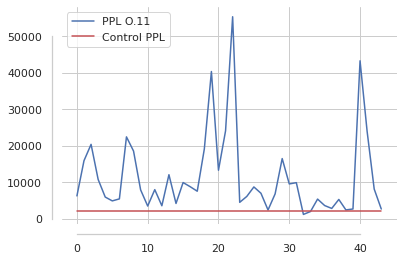

In [ ]:
ax = ob11.PPL.plot(label="PPL O.11"); 
plt.plot([ppl_adj(olm, o_testset)]*ob11.shape[0], label="Control PPL", color="r")
sns.set_style("whitegrid");sns.despine(offset=10, trim=True); ax.set(xlabel=None);
plt.legend(loc="upper left");

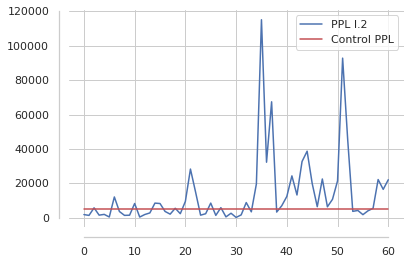

In [ ]:
ib2.PPL.plot(label="PPL I.2");
plt.plot([ppl_adj(ilm, i_testset)]*ib2.shape[0], label="Control PPL", color="r")
sns.set_style("whitegrid");sns.despine(offset=10, trim=True); ax.set(xlabel=None);
plt.legend(loc="upper right");

* Leave-one-Book-out LM

In [ ]:
start, end = 2600, 9600
# concatenate texts from all but one book, which will serve as our testing text
iliad_training = [" ".join([b[start:end] for j,b in enumerate(iliad_rhapsodies) if i!=j]) for i in range(24)] 
odyss_training = [" ".join([b[start:end] for j,b in enumerate(odyss_rhapsodies) if i!=j]) for i in range(24)] 
# train 24 st. language models per poem, one for each combination of 23 merged books
iliad_models = [SLM(gram="CHAR").train(training_set) for training_set in iliad_training]
odyss_models = [SLM(gram="CHAR").train(training_set) for training_set in odyss_training]
# sample excerpts from the poems, excluding the tails
iliad_samples = [rhapsody[start : end] for rhapsody in iliad_rhapsodies]
odyss_samples = [rhapsody[start : end] for rhapsody in odyss_rhapsodies]

  0%|          | 0/24 [00:00<?, ?it/s]

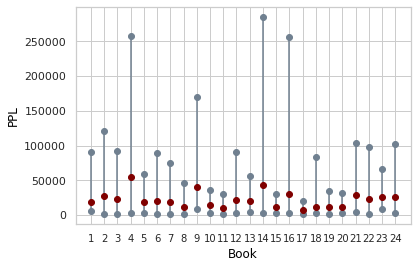

In [ ]:
c = .95
iliad_ppls = pd.DataFrame({i:[ppl_adj(iliad_models[i], sample(iliad_samples[i])) for _ in range(1000)] for i in tqdm(range(24))})
middle = iliad_ppls.mean(0).to_list()
left = iliad_ppls.quantile((1-c)/2).to_list()
right = iliad_ppls.quantile((1+c)/2).to_list() 
iliad_cis = pd.DataFrame({"left":left, "right":right, "middle":middle})

for book, r in iliad_cis.iterrows():
    plt.plot((book, book), (r.left,r.right), 'ro-', color='slategray') # plot a h-line at the height of the book
    plt.plot((book, ), (r.middle, ), 'ro-', color='maroon') # add the middle point

plt.xticks(range(24), iliad_cis.index+1, size = 10);
plt.xlabel(xlabel ='Book', color = 'black', size = 12, variant ='small-caps');
plt.ylabel(ylabel = 'PPL', color = 'black', size = 12, variant ='small-caps');
#plt.ylim([0,40]);

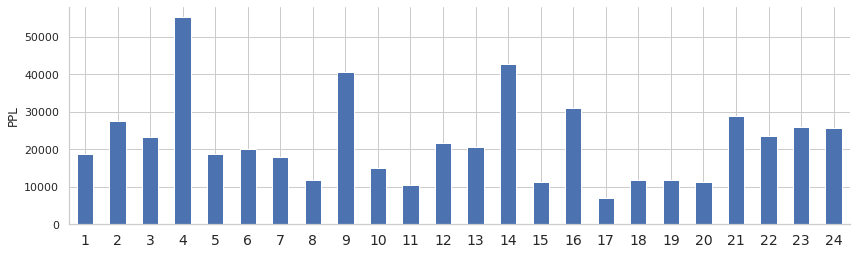

In [ ]:
sns.set_style("whitegrid")
iliad_ppls.mean(0).plot.bar(ylabel="PPL", figsize=(14,4));
plt.xticks(range(24), iliad_ppls.index+1, size = 14, rotation=0); sns.despine();

  0%|          | 0/24 [00:00<?, ?it/s]

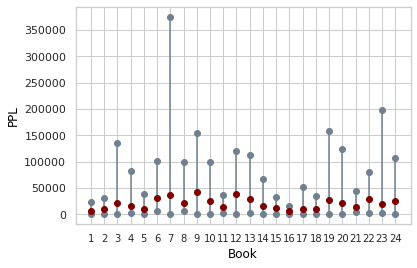

In [ ]:
odyss_ppls = pd.DataFrame({i:[ppl_adj(odyss_models[i], sample(odyss_samples[i])) for _ in range(1000)] for i in tqdm(range(24))})
middle = odyss_ppls.mean(0).to_list()
left = odyss_ppls.quantile((1-c)/2).to_list()
right = odyss_ppls.quantile((1+c)/2).to_list() 
odyss_cis = pd.DataFrame({"left":left, "right":right, "middle":middle})
for book, r in odyss_cis.iterrows():
    plt.plot((book, book), (r.left,r.right), 'ro-', color='slategray') # plot a h-line at the height of the book
    plt.plot((book, ), (r.middle, ), 'ro-', color='maroon') # add the middle point
plt.xticks(range(24), odyss_cis.index+1, size = 10);
plt.ylabel(ylabel = 'PPL', color = 'black', size = 12, variant ='small-caps');
plt.xlabel(xlabel ='Book', color = 'black', size = 12, variant ='small-caps');
#plt.ylim([0,40]);

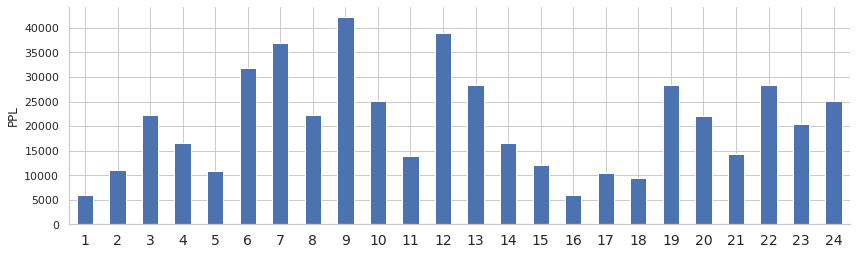

In [ ]:
sns.set_style("whitegrid")
odyss_ppls.mean(0).plot.bar(ylabel="PPL", figsize= (14,4));
plt.xticks(range(24), odyss_ppls.index+1, size = 14, rotation=0); sns.despine();

#### Correlation heatmaps book-wise
* Training a model on one book.
* Computing the BPC/PPL on others.
* Measuring the correlation between pairs of books.

In [ ]:
iblms = [SLM(gram="CHAR").train(book[2600:9600]) for i,book in enumerate(iliad_rhapsodies)]
oblms = [SLM(gram="CHAR").train(book[2600:9600]) for i,book in enumerate(odyss_rhapsodies)]

##### Heatmaps based on BPC scores

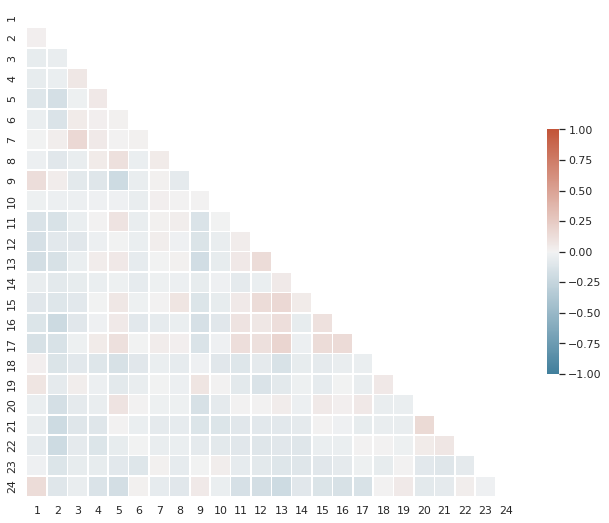

In [ ]:
ibppls = pd.DataFrame({i+1:[iblms[i].cross_entropy(iliad_rhapsodies[j]) for j in range(24)] for i in range(24)},index=range(1,25))
sns.set_theme(style="white"); corr = ibppls.corr()
f, ax = plt.subplots(figsize=(11, 9)); mask = np.triu(np.ones_like(corr, dtype=bool)); cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

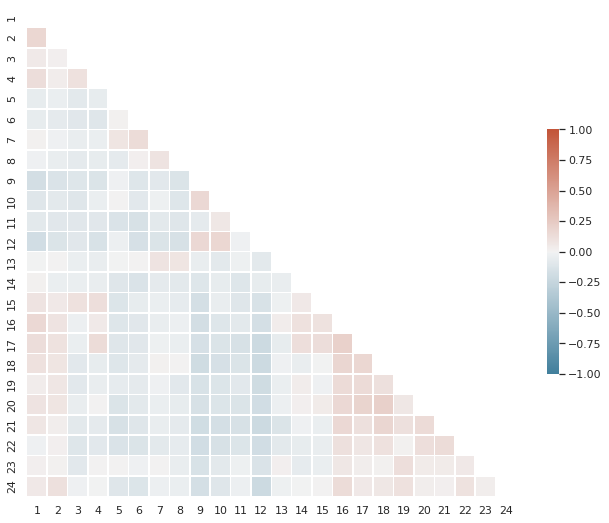

In [ ]:
obppls = pd.DataFrame({i+1:[oblms[i].cross_entropy(odyss_rhapsodies[j]) for j in range(24)] for i in range(24)},index=range(1,25))
sns.set_theme(style="white"); corr = obppls.corr()
f, ax = plt.subplots(figsize=(11, 9)); mask = np.triu(np.ones_like(corr, dtype=bool)); cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

##### Heatmaps based on PPL scores

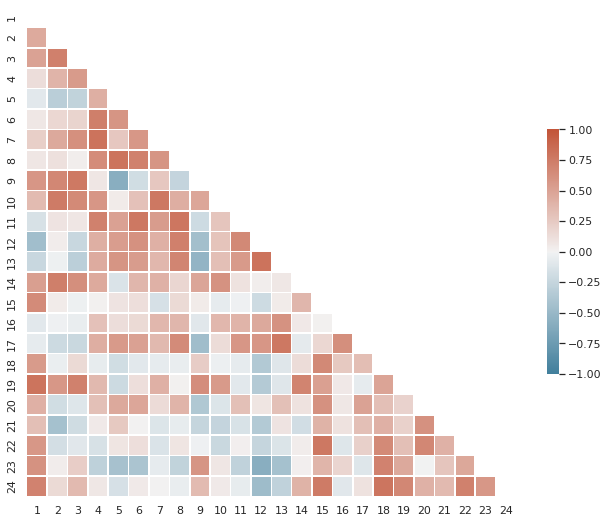

In [ ]:
ibppls = pd.DataFrame({i+1:[ppl_adj(iblms[i], iliad_rhapsodies[j]) for j in range(24)] for i in range(24)},index=range(1,25))
sns.set_theme(style="white"); corr = ibppls.corr(method="spearman")
f, ax = plt.subplots(figsize=(11, 9)); mask = np.triu(np.ones_like(corr, dtype=bool)); cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

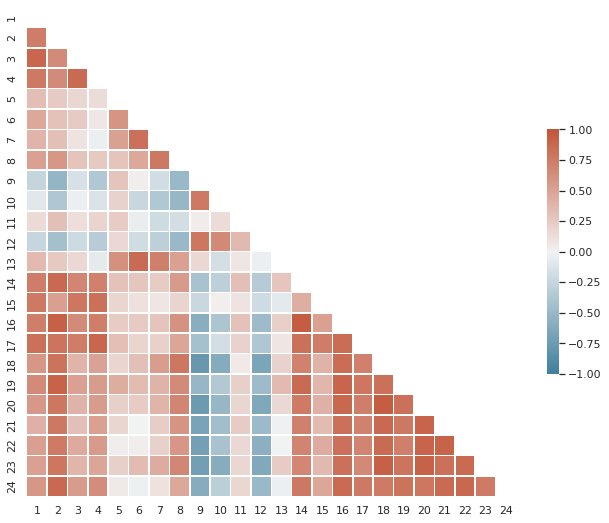

In [ ]:
obppls = pd.DataFrame({i+1:[ppl_adj(oblms[i], odyss_rhapsodies[j]) for j in range(24)] for i in range(24)},index=range(1,25))
sns.set_theme(style="white"); corr = obppls.corr(method="spearman")
f, ax = plt.subplots(figsize=(11, 9)); mask = np.triu(np.ones_like(corr, dtype=bool)); cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Poem Classification

In [ ]:
!gdown --id 1SbXNglxsu4iTvJ5a3TH8Pwi2Cf70tbsx
!gdown --id 1Wo_t3klWrEPKi1LViFvsyG-hbow8Xweu
keep_i = {0, 1, 3, 4, 5, 6, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23}
keep_o = {0, 1, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 18, 19, 21, 22, 23}
questionnaire = pd.read_excel("Questionnaire_Homer.xlsx")
questionnaire_gold = pd.read_excel("Questionnaire_correct_answers.xlsx")
questionnaire.text = questionnaire.text.str.lower().str.replace('[^\w\s]','')

Downloading...
From: https://drive.google.com/uc?id=1SbXNglxsu4iTvJ5a3TH8Pwi2Cf70tbsx
To: /content/Questionnaire_Homer.xlsx
100% 15.2k/15.2k [00:00<00:00, 26.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Wo_t3klWrEPKi1LViFvsyG-hbow8Xweu
To: /content/Questionnaire_correct_answers.xlsx
100% 8.54k/8.54k [00:00<00:00, 16.4MB/s]


In [ ]:
start,end = 2600, 9600
ilm = SLM(gram="CHAR").train(" ".join([b[start:end] for i,b in enumerate(iliad_rhapsodies) if i in keep_i]))
olm = SLM(gram="CHAR").train(" ".join([b[start:end] for i,b in enumerate(odyss_rhapsodies) if i in keep_o]))
hlmtc = lambda txt, ilm=ilm, olm=olm: int(ppl_adj(ilm, txt) < ppl_adj(olm, txt))
questionnaire["hlmtc"] = questionnaire.text.apply(hlmtc)
print(classification_report(questionnaire.label, questionnaire.hlmtc))
hlm_acc = accuracy_score(questionnaire.label, questionnaire.hlmtc)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.67      0.80         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12



In [ ]:
start,end = 2600, 9600
X = list(range(start+1, 3600, 10))
accs=[]
for e in tqdm(X):
  ilm = SLM(gram="CHAR").train(" ".join([b[start:e] for i,b in enumerate(iliad_rhapsodies) if i in keep_i]))
  olm = SLM(gram="CHAR").train(" ".join([b[start:e] for i,b in enumerate(odyss_rhapsodies) if i in keep_o]))
  hlmtc = lambda txt, ilm=ilm, olm=olm: int(ppl_adj(ilm, txt) < ppl_adj(olm, txt))
  questionnaire["hlmtc"] = questionnaire.text.apply(hlmtc)
  hlm_acc = accuracy_score(questionnaire.label, questionnaire.hlmtc)
  accs.append(hlm_acc)

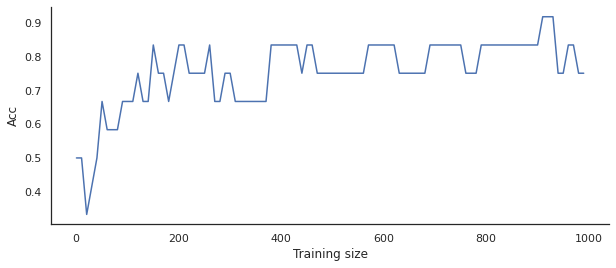

In [ ]:
scores = pd.DataFrame({"Acc":accs, "Training size":np.array(X)-start})
sns.lineplot(data=scores, x="Training size", y="Acc"); sns.despine();

In [ ]:
gold = pd.read_excel("Questionnaire_right_answers_new.xlsx", header=None).iloc[0]
annots = pd.read_excel("Annotators_answers_homeric_epics.xlsx", header=None).transpose()
print(f"Mean pairwise Kappa: {np.mean([kappa(annots[i], annots[j]) for i in range(12) for j in range(12) if i>j]):.2f}")
Acc = [accuracy_score(annots[i].to_list(), gold.to_list()) for i in range(annots.shape[1])]+[hlm_acc]
IDS = [f"H{i}" for i in range(annots.shape[1])]+["HLMTC"]
pd.DataFrame({"Accuracy": Acc, 
              "ID":IDS}).sort_values(by="Accuracy").plot.bar(x="ID",y="Accuracy",
                                                             color=["b"]*20+["r"]+["b"]*4,
                                                             figsize=(8,6))
                                                               
plt.ylim([0,1])